In [1]:
import os
from pathlib import Path
from PIL import Image
import cv2
import numpy as np
import json
from shapely.geometry import Polygon
import image_slicer
import time

# DeepLab code:
# taken from https://gluon-cv.mxnet.io/build/examples_segmentation/demo_deeplab.html
# dataset description https://groups.csail.mit.edu/vision/datasets/ADE20K/, https://github.com/dmlc/gluon-cv/blob/master/gluoncv/data/ade20k/segmentation.py
# deeplab code https://github.com/dmlc/gluon-cv/blob/master/gluoncv/model_zoo/deeplabv3.py

import mxnet as mx
from mxnet import image
from mxnet.gluon.data.vision import transforms
import gluoncv
from gluoncv.data.transforms.presets.segmentation import test_transform
# using cpu
ctx = mx.cpu(0)

# OCR code
#import pytesseract
#from pytesseract import Output
import OCR_utils as OCR_u

# If you don't have tesseract executable in your PATH, include the following:
#pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe' # Path('C:/Program Files\ Tesseract-OCR\ tesseract').as_posix()


# Scene recognition imports
from Keras_VGG16_places365.vgg16_places_365 import VGG16_Places365
from cv2 import resize


import evaluation_utils as eval_u
import deeplab_utils as dl_u

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
### (Code for testing, now useless)
"""
#image_list_deeplab, list_image_names_deeplab, list_ratio = eval_u.prepare_dataset('../small_10_test2017/', 'deeplab', True)
image_list_deeplab, list_image_names_deeplab, list_ratio, list_shapes = eval_u.prepare_dataset('../1_test2017/', 'deeplab', True)
model_deeplab = eval_u.load_model('deeplab')
output_pred_deeplab = eval_u.get_predictions(image_list_deeplab, 'deeplab', model_deeplab)
print(output_pred_deeplab[0][0].shape)
print(output_pred_deeplab[0][1].shape)
#outp = mx.nd.squeeze(mx.nd.argmax(output_pred_deeplab[0], 1)).asnumpy()
print(output_pred_deeplab[0][1].shape)
print(type(output_pred_deeplab[0][1]))
#print(np.unique(output_pred_deeplab[0][1]))
# Resizing image test

#from skimage.transform import resize
#testresize = resize(output_pred_deeplab[0][1].asnumpy(), (list_shapes[0][0], list_shapes[0][1]))
#print(testresize.shape)
#print(testresize)

# Test output with probabilities
output = dl_u.deeplab_pred_to_output(output_pred_deeplab[0][1], False, True, output_pred_deeplab[0][0], True, list_shapes[0])

output = dl_u.deeplab_pred_to_output(output_pred_deeplab[0][1])
"""

"\n#image_list_deeplab, list_image_names_deeplab, list_ratio = eval_u.prepare_dataset('../small_10_test2017/', 'deeplab', True)\nimage_list_deeplab, list_image_names_deeplab, list_ratio, list_shapes = eval_u.prepare_dataset('../1_test2017/', 'deeplab', True)\nmodel_deeplab = eval_u.load_model('deeplab')\noutput_pred_deeplab = eval_u.get_predictions(image_list_deeplab, 'deeplab', model_deeplab)\nprint(output_pred_deeplab[0][0].shape)\nprint(output_pred_deeplab[0][1].shape)\n#outp = mx.nd.squeeze(mx.nd.argmax(output_pred_deeplab[0], 1)).asnumpy()\nprint(output_pred_deeplab[0][1].shape)\nprint(type(output_pred_deeplab[0][1]))\n#print(np.unique(output_pred_deeplab[0][1]))\n# Resizing image test\n\n#from skimage.transform import resize\n#testresize = resize(output_pred_deeplab[0][1].asnumpy(), (list_shapes[0][0], list_shapes[0][1]))\n#print(testresize.shape)\n#print(testresize)\n\n# Test output with probabilities\noutput = dl_u.deeplab_pred_to_output(output_pred_deeplab[0][1], False, True, 

In [3]:
## OCR
%matplotlib inline
path_image_folder = '../10_test2017/'
pathlist = Path(path_image_folder).glob('**/*.*')


list_img = []
list_img_name = []
list_output_OCR = []
for path in pathlist:
    start = time.time()
    print("---------------- Image ", path, "------------------")
    # Read data
    #img, img_name, _, _ = eval_u.prepare_sample(path, 'OCR', True)
    #OCR_u.get_OCR_predictions(str(path))
    print(type(str(path)))
    output_pred_OCR = eval_u.get_predictions([str(path)], 'OCR', True, False)
    #list_img.append(img)
    #list_img_name.append(img_name)
    list_output_OCR.append(output_pred_OCR)
    end = time.time()
    print("Time to process image: ", end - start)

---------------- Image  ..\10_test2017\2017_10000580.jpg ------------------
<class 'str'>
[INFO] loading EAST text detector...
Time to process image:  5.384558916091919
---------------- Image  ..\10_test2017\2017_10051027.jpg ------------------
<class 'str'>
[INFO] loading EAST text detector...
Time to process image:  1.2919414043426514
---------------- Image  ..\10_test2017\2017_10376474.jpg ------------------
<class 'str'>
[INFO] loading EAST text detector...
Time to process image:  47.80233597755432
---------------- Image  ..\10_test2017\2017_11174421.jpg ------------------
<class 'str'>
[INFO] loading EAST text detector...
Time to process image:  23.748621463775635
---------------- Image  ..\10_test2017\2017_11534654.jpg ------------------
<class 'str'>
[INFO] loading EAST text detector...
Time to process image:  48.88508987426758
---------------- Image  ..\10_test2017\2017_12465739.jpg ------------------
<class 'str'>
[INFO] loading EAST text detector...
Time to process image:  36

In [3]:
print(list_output_OCR)

[[[((671, 308, 821, 385), 'lag)'), ((844, 384, 992, 449), '|')]], [[]], [[((18, 336, 130, 373), 'a\n\nahr yh'), ((883, 482, 1730, 650), 'RaANAAC'), ((499, 690, 787, 859), 'MANIIEI\n\n- SENOR Wi'), ((632, 719, 1186, 855), 'OR WALTRAPAS S.L.'), ((1032, 730, 1179, 852), 'ie oe. a\n\nS.L'), ((414, 799, 535, 876), 'Cy'), ((1081, 809, 1531, 893), '= ZARAGOZA'), ((709, 812, 1052, 884), '77 7\n\n_ LASALA 22'), ((495, 814, 811, 892), 'MANUEL L/'), ((984, 817, 1071, 882), 'a'), ((617, 868, 1158, 947), 'B99937552'), ((704, 990, 1131, 1077), 'EMPLEADO 1'), ((347, 1008, 819, 1094), '| Y@ndedor: EM'), ((1104, 1049, 1379, 1133), 'Mesa: M'), ((1313, 1051, 1552, 1130), 'MESA 5'), ((680, 1055, 1185, 1149), '. 01/040653 Ml'), ((407, 1077, 660, 1162), 'Picket'), ((1297, 1116, 1614, 1196), '15:49'), ((1102, 1120, 1362, 1198), 'Hora:'), ((726, 1127, 1205, 1218), '14/03/2015 Ho'), ((324, 1148, 639, 1235), '| Fecha'), ((1565, 1246, 1869, 1333), 'Total'), ((1197, 1252, 1564, 1346), 'Precio'), ((456, 1279, 970,

In [26]:
print(len(list_output_OCR))
#print(list_output_OCR[2])
ss = SymSpell(max_edit_distance=2)

words_dict = prepare_corrector('479k-english-words/english_words_479k.txt', ss)

processed_output_OCR = []
for output_OCR in list_output_OCR[2][0]:
    position = output_OCR[0]
    list_processed = [output_OCR[1], correction(output_OCR[1]), correction_prediction(output_OCR[1], words_dict, ss)]
    #print(correction(output_OCR[1]))
    #print(correction_prediction(output_OCR[1], words_dict, ss))
    processed_output_OCR.append((position, list_processed))

10
['2', '1080', '&c', '10-point', '10th']
Total english words: 466544
create symspell dict...
total words processed: 466544
total unique words in corpus: 0
total items in dictionary (corpus words and deletions): 20219955
  edit distance for deletions: 2
  length of longest word in corpus: 45
a

ahr yh
a ahir yeh
RaANAAC

MANIIEI

- SENOR Wi
e- i
OR WALTRAPAS S.L.
l.t.
ie oe. a

S.L
ie oe g. a g.
by
y
= ZARAGOZA

77 7

_ LASALA 22
7th 7th 2
MANUEL L/
w/
a
a
B99937552

EMPLEADO 1
l1
| Y@ndedor: EM
EM
Mesa: M
esa
MESA 5
l5
. 01/040653 Ml
g. l
picket
ticket
154

moral
ora
14/03/2015 Ho
o
| Fecha
recha
total
rotal
Precio
preciso
d Descripcion
d rescription
ipeLon
peon
Unid D
nid D
on ee ae
on ee ae
wae si Ame
wae si me
500
tp0 tp0
00
1080
25
x25
} horeca
horsecar
y menu hi
y menu hi
undo
unido
IVA |

quota
quota
Bases |!
pases
po
po
tent
tenet
0
tp0
102
10th
45
l5
50,00. tur.
g. tur g.
IViTie WA
WA
0,00 E
E
= Entrega: 50,
strega tp0
our
Eur
POR
POR
SU VISITA.
SU g.
GRACIAS PO
PO
of
SU


In [14]:
def printOCR(list_words, image_path):
    print(list_words)
    img = cv2.imread(image_path, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for word in list_words:
        #img = cv2.rectangle(img, (word[1][0], word[1][1]), (word[1][0] + word[1][2], word[1][1] + word[1][3]), (0, 255, 0), 2)
        img = cv2.rectangle(img, (word[0][0], word[0][1]), (word[0][2], word[0][3]), (0, 255, 0), 2)
    #img = cv2.resize(img, (960, 540))  # Resize image
    

    plt.imshow(img)

#    cv2.imshow('img', img)
#    cv2.waitKey(0)
#    cv2.destroyAllWindows()

[((18, 336, 130, 373), 'a\n\nahr yh'), ((883, 482, 1730, 650), 'RaANAAC'), ((499, 690, 787, 859), 'MANIIEI\n\n- SENOR Wi'), ((632, 719, 1186, 855), 'OR WALTRAPAS S.L.'), ((1032, 730, 1179, 852), 'ie oe. a\n\nS.L'), ((414, 799, 535, 876), 'Cy'), ((1081, 809, 1531, 893), '= ZARAGOZA'), ((709, 812, 1052, 884), '77 7\n\n_ LASALA 22'), ((495, 814, 811, 892), 'MANUEL L/'), ((984, 817, 1071, 882), 'a'), ((617, 868, 1158, 947), 'B99937552'), ((704, 990, 1131, 1077), 'EMPLEADO 1'), ((347, 1008, 819, 1094), '| Y@ndedor: EM'), ((1104, 1049, 1379, 1133), 'Mesa: M'), ((1313, 1051, 1552, 1130), 'MESA 5'), ((680, 1055, 1185, 1149), '. 01/040653 Ml'), ((407, 1077, 660, 1162), 'Picket'), ((1297, 1116, 1614, 1196), '15:49'), ((1102, 1120, 1362, 1198), 'Hora:'), ((726, 1127, 1205, 1218), '14/03/2015 Ho'), ((324, 1148, 639, 1235), '| Fecha'), ((1565, 1246, 1869, 1333), 'Total'), ((1197, 1252, 1564, 1346), 'Precio'), ((456, 1279, 970, 1377), 'd Descripcion'), ((683, 1285, 1027, 1378), 'ipeLon'), ((312, 129

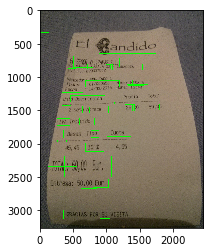

In [15]:
image_id = 2
id_im = 0
pathlist = Path(path_image_folder).glob('**/*.*')

for path in pathlist:
    if id_im == image_id:
        break
    id_im += 1
#print(type(path))
printOCR(list_output_OCR[image_id][0], str(path))
#printOCR(list_output_OCR[image_id][0], '2017_12571467.jpg')

1)

.o>

oe?

wi a

ad

Oe

get

go

; arte

ceed

aa

Ae

aan

a 0 O"

) Ser

34.00 S

(AS

ser 4

44,00 St

5 DOES

ario DO

eink

Guthrie

Arlo G

eunnne |

woody GY

g@.00p

A

non, V*

31.00 Se

) Ser 4-5

31.00 S

o Guthrie

Mrlo

) DOES

ARLO DX

| -Qpas/2013

y Guthrie

g Woody Gi

honoring We



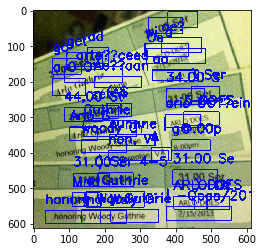

In [44]:
image_id = 8
id_im = 0
pathlist = Path(path_image_folder).glob('**/*.*')

for path in pathlist:
    if id_im == image_id:
        break
    id_im += 1
OCR_u.visualize_OCR_predictions(list_output_OCR[image_id][0], str(path), True)

In [16]:
### Handling misspellings

import re
from collections import Counter

def words(text): return re.findall(r'\w+', text.lower())

WORDS = Counter(words(open('big.txt').read()))

def P(word, N=sum(WORDS.values())): 
    "Probability of `word`."
    return WORDS[word] / N

def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

In [29]:
correction('winstein')

'winston'

In [8]:
## Semantic segmentation

# Restructure to obtain data image per image instead of loading everything.
path_image_folder = '../10_test2017/'
pathlist = Path(path_image_folder).glob('**/*.*')


list_img = []
list_img_name = []
list_img_ratio = []
list_img_shapes = []
list_output = []
for path in pathlist:
    start = time.time()
    print("---------------- Image ", path, "------------------")
    # Read data
    #image_list_deeplab, list_image_names_deeplab, list_ratio, list_shapes = eval_u.prepare_dataset('../1_test2017/', 'deeplab', True)
    img, img_name, img_ratio, img_shapes = eval_u.prepare_sample(path, 'deeplab', True)
    # Get predictions
    model_deeplab = eval_u.load_model('deeplab')
    output_pred_deeplab = eval_u.get_predictions([img], 'deeplab', model_deeplab)
    # Post process to polygon
    #output = dl_u.deeplab_pred_to_output(output_pred_deeplab[0][1], False, True, output_pred_deeplab[0][0])
    output = dl_u.deeplab_pred_to_output(output_pred_deeplab[0][1], False, True, output_pred_deeplab[0][0], True, img_shapes)
    list_img.append(img)
    list_img_name.append(img_name)
    list_img_ratio.append(img_ratio)
    list_img_shapes.append(img_shapes)
    list_output.append(output)
    end = time.time()
    print("Time to process image: ", end - start)

---------------- Image  ..\10_test2017\2017_10000580.jpg ------------------
predicting
calculating labels
calculating probabilities.
Creating masks.
Resizing image prediction.
Number of classes with masks to create:  10
Number of classes with masks to create:  10
Time to process image:  44.175337076187134
---------------- Image  ..\10_test2017\2017_10051027.jpg ------------------
predicting
calculating labels
calculating probabilities.
Creating masks.
Resizing image prediction.
Number of classes with masks to create:  3
Number of classes with masks to create:  3
Time to process image:  18.08584237098694
---------------- Image  ..\10_test2017\2017_10376474.jpg ------------------
predicting
calculating labels
calculating probabilities.
Creating masks.
Resizing image prediction.
Number of classes with masks to create:  10
Number of classes with masks to create:  10
Time to process image:  53.603103160858154
---------------- Image  ..\10_test2017\2017_11174421.jpg ------------------
predic

In [10]:
"""
# Getting confidence for polygon.
print(output[0])
x, y = output[0][0][0].exterior.coords.xy
print(list(output[0][0][0].exterior.coords.xy))
print((np.frombuffer(x).astype(int)), np.frombuffer(y).astype(int))
x = np.frombuffer(x).astype(int)
y = np.frombuffer(y).astype(int)

from scipy.ndimage.morphology import binary_fill_holes as imfill

mask = np.zeros((image_list_deeplab[0].shape[2], image_list_deeplab[0].shape[3]),dtype=bool)
mask[x, y] = 1
img_proba = output_pred_deeplab[0][0][0, output[0][2], :, :]
out = img_proba[imfill(mask)].sum() / img_proba[imfill(mask)].shape[0]

mask.shape
print(np.unique(mask))
print(imfill(mask))
print(img_proba[imfill(mask)])
print(out)
"""

'\n# Getting confidence for polygon.\nprint(output[0])\nx, y = output[0][0][0].exterior.coords.xy\nprint(list(output[0][0][0].exterior.coords.xy))\nprint((np.frombuffer(x).astype(int)), np.frombuffer(y).astype(int))\nx = np.frombuffer(x).astype(int)\ny = np.frombuffer(y).astype(int)\n\nfrom scipy.ndimage.morphology import binary_fill_holes as imfill\n\nmask = np.zeros((image_list_deeplab[0].shape[2], image_list_deeplab[0].shape[3]),dtype=bool)\nmask[x, y] = 1\nimg_proba = output_pred_deeplab[0][0][0, output[0][2], :, :]\nout = img_proba[imfill(mask)].sum() / img_proba[imfill(mask)].shape[0]\n\nmask.shape\nprint(np.unique(mask))\nprint(imfill(mask))\nprint(img_proba[imfill(mask)])\nprint(out)\n'

In [11]:
print(output)

[([(<shapely.geometry.polygon.Polygon object at 0x000001B450DA8F88>, 0.05650999148686727), (<shapely.geometry.polygon.Polygon object at 0x000001B450D8D788>, 0.15555193424224853), (<shapely.geometry.polygon.Polygon object at 0x000001B4513C5FC8>, 0.13319347644674367), (<shapely.geometry.polygon.Polygon object at 0x000001B4513C5F88>, 0.11957741946708865), (<shapely.geometry.polygon.Polygon object at 0x000001B4513C5C88>, 0.06050040821234385), (<shapely.geometry.polygon.Polygon object at 0x000001B4513C59C8>, 0.1418322675368365), (<shapely.geometry.polygon.Polygon object at 0x000001B4513C58C8>, 0.09715843828100908)], 'wall', 0), ([(<shapely.geometry.polygon.Polygon object at 0x000001B439F9F048>, 0.0024550985544919968)], 'person, individual, someone, somebody, mortal, soul', 12), ([(<shapely.geometry.polygon.Polygon object at 0x000001B4513C5EC8>, 7.849202180902164e-05), (<shapely.geometry.polygon.Polygon object at 0x000001B4513C5908>, 0.00019977344200015069), (<shapely.geometry.polygon.Polygo

In [12]:
print(output[0][0][0])

(<shapely.geometry.polygon.Polygon object at 0x000001B450DA8F88>, 0.05650999148686727)


In [9]:
def print_plot_semantic_segmentation(image_path, output, class_object=[]):
    print("----------- Image ", image_path, "----------------")
    
    list_poly = []
    img = image.imread(image_path)
    fig, ax = plt.subplots()
    ax.imshow(img.asnumpy())
    for poly_type in output:
        if len(class_object) > 0:
            if poly_type[1] in class_object:
                list_poly.append(poly_type[0])
                for poly in poly_type[0]:
                    x,y = poly[0].exterior.xy
                    ax.plot(x,y ,  linewidth=5)
        else:
            for poly in poly_type[0]:
                x,y = poly[0].exterior.xy
                ax.plot(x,y ,  linewidth=5)
                
    if len(class_object) > 0:
        print(list_poly)
    else:
        print(output)
    plt.show()

----------- Image  ..\10_test2017\2017_11174421.jpg ----------------
[([(<shapely.geometry.polygon.Polygon object at 0x000001DFD0E07148>, 0.19378744065761566), (<shapely.geometry.polygon.Polygon object at 0x000001DFD0E07788>, 0.30791656594527395), (<shapely.geometry.polygon.Polygon object at 0x000001DFD0E07C48>, 0.2501736084620158), (<shapely.geometry.polygon.Polygon object at 0x000001DFD0E073C8>, 0.21388175455729166), (<shapely.geometry.polygon.Polygon object at 0x000001DFBD526348>, 0.07761782918657575), (<shapely.geometry.polygon.Polygon object at 0x000001DFBD526288>, 0.18869145711263022), (<shapely.geometry.polygon.Polygon object at 0x000001DFBD526188>, 0.1580247481664022), (<shapely.geometry.polygon.Polygon object at 0x000001DFBD526F88>, 0.209756072686643), (<shapely.geometry.polygon.Polygon object at 0x000001DFBD526E48>, 0.09339323971006605), (<shapely.geometry.polygon.Polygon object at 0x000001DFBD5260C8>, 0.1121748924255371), (<shapely.geometry.polygon.Polygon object at 0x000001

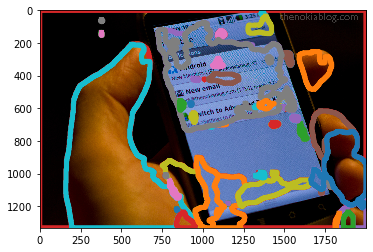

----------- Image  ..\10_test2017\2017_11174421.jpg ----------------
[[(<shapely.geometry.polygon.Polygon object at 0x000001DFBD526248>, 0.004646331071853638), (<shapely.geometry.polygon.Polygon object at 0x000001DFBD526708>, 0.010898551658580178), (<shapely.geometry.polygon.Polygon object at 0x000001DFD0E06C48>, 0.022348791360855103), (<shapely.geometry.polygon.Polygon object at 0x000001DFD0E06C88>, 0.014882301330566406), (<shapely.geometry.polygon.Polygon object at 0x000001DFD0E06048>, 0.025376365865979876), (<shapely.geometry.polygon.Polygon object at 0x000001DFD0E06DC8>, 0.007539571821689605), (<shapely.geometry.polygon.Polygon object at 0x000001DFD0E06348>, 0.03446235507726669)]]


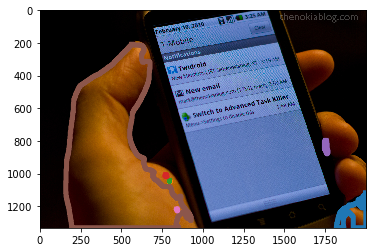

In [11]:
image_id = 3
id_im = 0
pathlist = Path(path_image_folder).glob('**/*.*')

for path in pathlist:
    if id_im == image_id:
        break
    id_im += 1
#print(path)
print_plot_semantic_segmentation(path, list_output[image_id])
print_plot_semantic_segmentation(path, list_output[image_id], ["person, individual, someone, somebody, mortal, soul", 'painting, picture'])

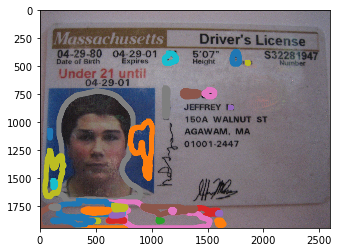

In [13]:
# Test plotting the image and polygons

import matplotlib.pyplot as plt

img = image.imread(path)

#plt.imshow(img.asnumpy())

"""
for poly in output[1][0]:
    #x,y = output[0][0][0][0].exterior.xy
    x,y = poly[0].exterior.xy
    #print(x)
    plt.plot(x,y)

#plt.show()
"""


#x,y = output[1][0][0][0].exterior.xy
fig, ax = plt.subplots()
ax.imshow(img.asnumpy()) #, extent=[0, 3000, 0, 3000])
#ax.autoscale(False)
for poly_type in output:
    for poly in poly_type[0]:
        x,y = poly[0].exterior.xy
        ax.plot(x,y ,  linewidth=5)
plt.show()


In [3]:
def simple_rule_based_obfuscation(output_deeplab):
    # Later we can save other things like the "sky" to decide to hide it
    true_output = []
    for poly in output_deeplab:
        if (poly[1] == "person, individual, someone, somebody, mortal, soul") or (poly[1] == "bookcase") or (poly[1] == "computer, computing machine, computing device, data processor, ") or (poly[1] == "trade name, brand name, brand, marque") :
            true_output.append(poly)
    return true_output

In [4]:
#print(type(output_pred_deeplab[0]))

In [ ]:
def ruleBasedMapping(type_semantic_seg_rule, type_OCR_rule, type_scene_rule, list_semantic_segmentation, list_OCR, list_scene):
    polys_to_obfuscate = []

    if type_semantic_seg_rule == "simple_list":
        list_private_deeplab_labels = ["person, individual, someone, somebody, mortal, soul", \
                                   "car, auto, automobile, machine, motorcar", \
                   "bus, autobus, coach, charabanc, double-decker, jitney, motorbus, ", \
                   "motorcoach, omnibus, passenger vehicle", "truck, motortruck", "van", 
                   "conveyer belt, conveyor belt, conveyer, conveyor, transporter",  "minibike, motorbike", \
                   "bicycle, bike, wheel, cycle", "poster, posting, placard, notice, bill, card", \
                   "signboard sign", "bulletin board, notice board", \
                  "screen door, screen",  "screen, silver screen, projection screen", \
                  "crt screen", "plate", "monitor, monitoring device", \
                   "bookcase", "blind, screen", "book", "computer, computing machine, computing device, data processor ", \
                    "electronic computer, information processing system", \
                    "television receiver, television, television set, tv, tv set, idiot ", \
                    "trade name, brand name, brand, marque", "flag"]
        for poly in list_semantic_segmentation:
            print("TODO: add filter per confidence score")
            if poly[1] in list_private_deeplab_labels:
                if # Check that the size of the polygons is large enough to actually see anything on the images.
                polys_to_obfuscate.append(poly)
                
    if type_OCR_rule == "simple_rule":
        print("TO IMPLEMENT")
        
    
    return polys_to_obfuscate

In [5]:
list_true_output = []
for output in list_output:
    list_true_output.append(simple_rule_based_obfuscation(output))
#true_output = simple_rule_based_obfuscation(list_output)
print(list_true_output)

In [23]:
"""
https://www.kaggle.com/yk1598/symspell-spell-corrector/code

The spell checker has been entirely ripped off of this script by Serg Lavrikov(rumbok):
https://www.kaggle.com/rumbok/ridge-lb-0-41944

do check it out, its a work of art.

caveat: script consumes a lot of memory but is much faster than Norvig's spell checker (1 million times)
http://blog.faroo.com/2015/03/24/fast-approximate-string-matching-with-large-edit-distances/
"""

import re, random
import spacy
nlp = spacy.load('en_core_web_sm')

to_sample = False # if you're impatient switch this flag

def spacy_tokenize(text):
    return [token.text for token in nlp.tokenizer(text)]
    
def dameraulevenshtein(seq1, seq2):
    """Calculate the Damerau-Levenshtein distance between sequences.
    This method has not been modified from the original.
    Source: http://mwh.geek.nz/2009/04/26/python-damerau-levenshtein-distance/
    This distance is the number of additions, deletions, substitutions,
    and transpositions needed to transform the first sequence into the
    second. Although generally used with strings, any sequences of
    comparable objects will work.
    Transpositions are exchanges of *consecutive* characters; all other
    operations are self-explanatory.
    This implementation is O(N*M) time and O(M) space, for N and M the
    lengths of the two sequences.
    >>> dameraulevenshtein('ba', 'abc')
    2
    >>> dameraulevenshtein('fee', 'deed')
    2
    It works with arbitrary sequences too:
    >>> dameraulevenshtein('abcd', ['b', 'a', 'c', 'd', 'e'])
    2
    """
    # codesnippet:D0DE4716-B6E6-4161-9219-2903BF8F547F
    # Conceptually, this is based on a len(seq1) + 1 * len(seq2) + 1 matrix.
    # However, only the current and two previous rows are needed at once,
    # so we only store those.
    oneago = None
    thisrow = list(range(1, len(seq2) + 1)) + [0]
    for x in range(len(seq1)):
        # Python lists wrap around for negative indices, so put the
        # leftmost column at the *end* of the list. This matches with
        # the zero-indexed strings and saves extra calculation.
        twoago, oneago, thisrow = (oneago, thisrow, [0] * len(seq2) + [x + 1])
        for y in range(len(seq2)):
            delcost = oneago[y] + 1
            addcost = thisrow[y - 1] + 1
            subcost = oneago[y - 1] + (seq1[x] != seq2[y])
            thisrow[y] = min(delcost, addcost, subcost)
            # This block deals with transpositions
            if (x > 0 and y > 0 and seq1[x] == seq2[y - 1]
                    and seq1[x - 1] == seq2[y] and seq1[x] != seq2[y]):
                thisrow[y] = min(thisrow[y], twoago[y - 2] + 1)
    return thisrow[len(seq2) - 1]


class SymSpell:
    def __init__(self, max_edit_distance=3, verbose=0):
        self.max_edit_distance = max_edit_distance
        self.verbose = verbose
        # 0: top suggestion
        # 1: all suggestions of smallest edit distance
        # 2: all suggestions <= max_edit_distance (slower, no early termination)

        self.dictionary = {}
        self.longest_word_length = 0

    def get_deletes_list(self, w):
        """given a word, derive strings with up to max_edit_distance characters
           deleted"""

        deletes = []
        queue = [w]
        for d in range(self.max_edit_distance):
            temp_queue = []
            for word in queue:
                if len(word) > 1:
                    for c in range(len(word)):  # character index
                        word_minus_c = word[:c] + word[c + 1:]
                        if word_minus_c not in deletes:
                            deletes.append(word_minus_c)
                        if word_minus_c not in temp_queue:
                            temp_queue.append(word_minus_c)
            queue = temp_queue

        return deletes

    def create_dictionary_entry(self, w):
        '''add word and its derived deletions to dictionary'''
        # check if word is already in dictionary
        # dictionary entries are in the form: (list of suggested corrections,
        # frequency of word in corpus)
        new_real_word_added = False
        if w in self.dictionary:
            # increment count of word in corpus
            self.dictionary[w] = (self.dictionary[w][0], self.dictionary[w][1] + 1)
        else:
            self.dictionary[w] = ([], 1)
            self.longest_word_length = max(self.longest_word_length, len(w))

        if self.dictionary[w][1] == 1:
            # first appearance of word in corpus
            # n.b. word may already be in dictionary as a derived word
            # (deleting character from a real word)
            # but counter of frequency of word in corpus is not incremented
            # in those cases)
            new_real_word_added = True
            deletes = self.get_deletes_list(w)
            for item in deletes:
                if item in self.dictionary:
                    # add (correct) word to delete's suggested correction list
                    self.dictionary[item][0].append(w)
                else:
                    # note frequency of word in corpus is not incremented
                    self.dictionary[item] = ([w], 0)

        return new_real_word_added

    def create_dictionary_from_arr(self, arr, token_pattern=r'[a-z]+'):
        total_word_count = 0
        unique_word_count = 0

        for line in arr:
            # separate by words by non-alphabetical characters
            words = re.findall(token_pattern, line.lower())
            for word in words:
                total_word_count += 1
                if self.create_dictionary_entry(word):
                    unique_word_count += 1

        print("total words processed: %i" % total_word_count)
        print("total unique words in corpus: %i" % unique_word_count)
        print("total items in dictionary (corpus words and deletions): %i" % len(self.dictionary))
        print("  edit distance for deletions: %i" % self.max_edit_distance)
        print("  length of longest word in corpus: %i" % self.longest_word_length)
        return self.dictionary

    def create_dictionary(self, fname):
        total_word_count = 0
        unique_word_count = 0

        with open(fname) as file:
            for line in file:
                # separate by words by non-alphabetical characters
                words = re.findall('[a-z]+', line.lower())
                for word in words:
                    total_word_count += 1
                    if self.create_dictionary_entry(word):
                        unique_word_count += 1

        print("total words processed: %i" % total_word_count)
        print("total unique words in corpus: %i" % unique_word_count)
        print("total items in dictionary (corpus words and deletions): %i" % len(self.dictionary))
        print("  edit distance for deletions: %i" % self.max_edit_distance)
        print("  length of longest word in corpus: %i" % self.longest_word_length)
        return self.dictionary

    def get_suggestions(self, string, silent=False):
        """return list of suggested corrections for potentially incorrectly
           spelled word"""
        if (len(string) - self.longest_word_length) > self.max_edit_distance:
            if not silent:
                print("no items in dictionary within maximum edit distance")
            return []

        suggest_dict = {}
        min_suggest_len = float('inf')

        queue = [string]
        q_dictionary = {}  # items other than string that we've checked

        while len(queue) > 0:
            q_item = queue[0]  # pop
            queue = queue[1:]

            # early exit
            if ((self.verbose < 2) and (len(suggest_dict) > 0) and
                    ((len(string) - len(q_item)) > min_suggest_len)):
                break

            # process queue item
            if (q_item in self.dictionary) and (q_item not in suggest_dict):
                if self.dictionary[q_item][1] > 0:
                    # word is in dictionary, and is a word from the corpus, and
                    # not already in suggestion list so add to suggestion
                    # dictionary, indexed by the word with value (frequency in
                    # corpus, edit distance)
                    # note q_items that are not the input string are shorter
                    # than input string since only deletes are added (unless
                    # manual dictionary corrections are added)
                    assert len(string) >= len(q_item)
                    suggest_dict[q_item] = (self.dictionary[q_item][1],
                                            len(string) - len(q_item))
                    # early exit
                    if (self.verbose < 2) and (len(string) == len(q_item)):
                        break
                    elif (len(string) - len(q_item)) < min_suggest_len:
                        min_suggest_len = len(string) - len(q_item)

                # the suggested corrections for q_item as stored in
                # dictionary (whether or not q_item itself is a valid word
                # or merely a delete) can be valid corrections
                for sc_item in self.dictionary[q_item][0]:
                    if sc_item not in suggest_dict:

                        # compute edit distance
                        # suggested items should always be longer
                        # (unless manual corrections are added)
                        assert len(sc_item) > len(q_item)

                        # q_items that are not input should be shorter
                        # than original string
                        # (unless manual corrections added)
                        assert len(q_item) <= len(string)

                        if len(q_item) == len(string):
                            assert q_item == string
                            item_dist = len(sc_item) - len(q_item)

                        # item in suggestions list should not be the same as
                        # the string itself
                        assert sc_item != string

                        # calculate edit distance using, for example,
                        # Damerau-Levenshtein distance
                        item_dist = dameraulevenshtein(sc_item, string)

                        # do not add words with greater edit distance if
                        # verbose setting not on
                        if (self.verbose < 2) and (item_dist > min_suggest_len):
                            pass
                        elif item_dist <= self.max_edit_distance:
                            assert sc_item in self.dictionary  # should already be in dictionary if in suggestion list
                            suggest_dict[sc_item] = (self.dictionary[sc_item][1], item_dist)
                            if item_dist < min_suggest_len:
                                min_suggest_len = item_dist

                        # depending on order words are processed, some words
                        # with different edit distances may be entered into
                        # suggestions; trim suggestion dictionary if verbose
                        # setting not on
                        if self.verbose < 2:
                            suggest_dict = {k: v for k, v in suggest_dict.items() if v[1] <= min_suggest_len}

            # now generate deletes (e.g. a substring of string or of a delete)
            # from the queue item
            # as additional items to check -- add to end of queue
            assert len(string) >= len(q_item)

            # do not add words with greater edit distance if verbose setting
            # is not on
            if (self.verbose < 2) and ((len(string) - len(q_item)) > min_suggest_len):
                pass
            elif (len(string) - len(q_item)) < self.max_edit_distance and len(q_item) > 1:
                for c in range(len(q_item)):  # character index
                    word_minus_c = q_item[:c] + q_item[c + 1:]
                    if word_minus_c not in q_dictionary:
                        queue.append(word_minus_c)
                        q_dictionary[word_minus_c] = None  # arbitrary value, just to identify we checked this

        # queue is now empty: convert suggestions in dictionary to
        # list for output
        if not silent and self.verbose != 0:
            print("number of possible corrections: %i" % len(suggest_dict))
            print("  edit distance for deletions: %i" % self.max_edit_distance)

        # output option 1
        # sort results by ascending order of edit distance and descending
        # order of frequency
        #     and return list of suggested word corrections only:
        # return sorted(suggest_dict, key = lambda x:
        #               (suggest_dict[x][1], -suggest_dict[x][0]))

        # output option 2
        # return list of suggestions with (correction,
        #                                  (frequency in corpus, edit distance)):
        as_list = suggest_dict.items()
        # outlist = sorted(as_list, key=lambda (term, (freq, dist)): (dist, -freq))
        outlist = sorted(as_list, key=lambda x: (x[1][1], -x[1][0]))

        if self.verbose == 0:
            return outlist[0]
        else:
            return outlist

        '''
        Option 1:
        ['file', 'five', 'fire', 'fine', ...]
        Option 2:
        [('file', (5, 0)),
         ('five', (67, 1)),
         ('fire', (54, 1)),
         ('fine', (17, 1))...]  
        '''

    def best_word(self, s, silent=False):
        try:
            return self.get_suggestions(s, silent)[0]
        except:
            return None

def spell_corrector(word_list, words_d, ss) -> str:
    result_list = []
    for word in word_list:
        if word not in words_d:
            suggestion = ss.best_word(word, silent=True)
            if suggestion is not None:
                result_list.append(suggestion)
        else:
            result_list.append(word)
            
    return " ".join(result_list)


def prepare_corrector(dictionary_file, ss):
    
      
    
    # fetch english words dictionary
    #with open('479k-english-words/english_words_479k.txt') as f:
    with open(dictionary_file) as f:

        words = f.readlines()
    eng_words = [word.strip() for word in words]
    
    # Print some examples
    print(eng_words[:5])

    print('Total english words: {}'.format(len(eng_words)))
    
    print('create symspell dict...')
    
    if to_sample:
        # sampling from list for kernel runtime
        sample_idxs = random.sample(range(len(eng_words)), 100)
        eng_words = [eng_words[i] for i in sorted(sample_idxs)] # make sure our sample misspell is in there
    
    all_words_list = list(set(eng_words))
    silence = ss.create_dictionary_from_arr(all_words_list, token_pattern=r'.+')
    
    # create a dictionary of rightly spelled words for lookup
    words_dict = {k: 0 for k in all_words_list}
    
    return words_dict
    
def correction_prediction(sample_text, words_dict, ss):
    tokens = spacy_tokenize(sample_text)
    
    #print('run spell checker...')
    #print()
    #print('original text: ' + sample_text)
    #print()
    correct_text = spell_corrector(tokens, words_dict, ss)
    return correct_text
"""    
if __name__ == '__main__':
    
    words_dict = prepare_corrector('479k-english-words/english_words_479k.txt')
    sample_text = 'to infifity and byond'
    correct_text = correction_prediction(sample_text, words_dict)
    print('corrected text: ' + correct_text)

    print('Done.')    
"""

# build symspell tree 
ss = SymSpell(max_edit_distance=2)

In [76]:
"""
sample_text = 'united stte'
tokens = spacy_tokenize(sample_text)
correct_text = spell_corrector(tokens, words_dict)
print('corrected text: ' + correct_text)
"""

"\nsample_text = 'united stte'\ntokens = spacy_tokenize(sample_text)\ncorrect_text = spell_corrector(tokens, words_dict)\nprint('corrected text: ' + correct_text)\n"

In [77]:
sample_text = 'united stte'
correct_text = correction_prediction(sample_text, words_dict)
print('corrected text: ' + correct_text)
print(correction(sample_text))

corrected text: united stite
united stte


In [82]:
import spacy 

#import en_core_web_sm
#nlp = en_core_web_sm.load()
sample_text = 'winstein'

language_list  = ['en_core_web_sm', 'de_core_news_sm']
for lang in language_list:
    
    nlp = spacy.load(lang)
    
    # Without correction
    doc = nlp(sample_text)
    print([(X.text, X.label_) for X in doc.ents])
    
    # With correction
    correct_text = correction_prediction(sample_text, words_dict)
    print('corrected text: ' + correct_text)
    doc = nlp(correct_text)
    print([(X.text, X.label_) for X in doc.ents])
    
    correct_text = correction(sample_text)
    print('other corrected text: ' + correct_text)
    doc = nlp(correct_text)
    print([(X.text, X.label_) for X in doc.ents])

    

    #doc = nlp('european authorities fined Google a record $5.1 billion on Wednesday for abusing its power in the mobile phone market and ordered the company to alter its practices')
    #print([(X.text, X.label_) for X in doc.ents])
    
    
"""
language_list_without_model = []

from spacy.lang.ja import Japanese
nlp = Japanese()  # use directly
nlp = spacy.blank("ja")  # blank instance
doc = nlp("i am french")
print(doc)
"""

[]
corrected text: weinstein
[]
other corrected text: winston
[('winston', 'ORG')]
[]
corrected text: weinstein
[('weinstein', 'LOC')]
other corrected text: winston
[('winston', 'PER')]


'\nlanguage_list_without_model = []\n\nfrom spacy.lang.ja import Japanese\nnlp = Japanese()  # use directly\nnlp = spacy.blank("ja")  # blank instance\ndoc = nlp("i am french")\nprint(doc)\n'

In [70]:
# NLTK Stanford old API:
# This needs correct spelling and even upper and lower cases.

from nltk.tag.stanford import StanfordNERTagger
from nltk.tokenize import word_tokenize  
#import nltk
#nltk.download('punkt')
import os
java_path = "C:\Program Files (x86)\Common Files\Oracle\Java\javapath\java.exe" #"C:/Program Files/Java/jdk1.8.0_161/bin/java.exe"
os.environ['JAVAHOME'] = java_path

def formatted_entities(classified_paragraphs_list):
    entities = []

    for classified_paragraph in classified_paragraphs_list:
        for entry in classified_paragraph:
            entry_value = entry[0]
            entry_type = entry[1]
            print(entry_value, entry_type)
            entities.append((entry_value, entry_type))
            #if entry_type == 'LOCATION': 
            #    entities.append(entry_value) 
    return entities 
    
tagger = StanfordNERTagger('english.all.3class.distsim.crf.ser.gz',
               'stanford-ner.jar',
               encoding='utf-8')
                
sample_text = 'France is a country'

city_ = word_tokenize(sample_text)     
classified_paragraphs_list = tagger.tag_sents([city_]) 
formatted_result = formatted_entities(classified_paragraphs_list)  
#print(formatted_result)
"""
    except Exception as e:  
        passed +=1
        print(i, city, 'error:', e)
        pass
    if i% 100 == 0: print (i, count, passed, city, city_, 'result:', ' '.join(formatted_result)) 
"""

France LOCATION
is O
a O
country O


"\n    except Exception as e:  \n        passed +=1\n        print(i, city, 'error:', e)\n        pass\n    if i% 100 == 0: print (i, count, passed, city, city_, 'result:', ' '.join(formatted_result)) \n"

In [71]:
print(formatted_result)

[('France', 'LOCATION'), ('is', 'O'), ('a', 'O'), ('country', 'O')]


In [113]:
# New version of nltk and ner

import pandas as pd
from nltk.parse import CoreNLPParser
import datetime

cities = pd.read_csv('us_cities_states_counties.csv')  
cities['City alias'] = cities['City alias'].apply(lambda x: str(x))
ner_tagger = CoreNLPParser(url='http://localhost:9000', tagtype='ner') 
parser = CoreNLPParser(url='http://localhost:9000')
def formatted_entities(classified_paragraphs_list):
    entities = []

    for classified_paragraph in classified_paragraphs_list:
        for entry in classified_paragraph:
            entry_value = entry[0]
            entry_type = entry[1]
            print(entry_value, entry_type)
            #if entry_type == 'LOCATION': 
            #    entities.append(entry_value) 
    return #entities 


currentDT = datetime.datetime.now()
print (str(currentDT))


sample_text = 'France is a country'
try:

city_ = parser.tokenize(sample_text)     

    classified_paragraphs_list = ner_tagger.tag_sents([city_]) 
    formatted_result = formatted_entities(classified_paragraphs_list)  

    currentDT = datetime.datetime.now()
    print (str(currentDT))
except Exception as e: 
    pass


2020-04-01 16:34:23.483031


ConnectionError: HTTPConnectionPool(host='localhost', port=9000): Max retries exceeded with url: /?properties=%7B%22outputFormat%22%3A+%22json%22%2C+%22annotators%22%3A+%22tokenize%2Cssplit%22%7D (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001539B6E9788>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it'))

In [31]:
# NLTK thrd version

import nltk
#nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
nltk.download('maxent_ne_chunker')
nltk.download('words')

ex = "I live in France. France is a country. French people are a popoulation."

def preprocess(sent):
    sent = nltk.word_tokenize(sent)
    sent = nltk.pos_tag(sent)
    return sent

sent = preprocess(ex)
pattern = 'NP: {<DT>?<JJ>*<NN>}'
cp = nltk.RegexpParser(pattern)
cs = cp.parse(sent)

from nltk.chunk import conlltags2tree, tree2conlltags
from pprint import pprint
iob_tagged = tree2conlltags(cs)
print(iob_tagged)


ne_tree = nltk.ne_chunk(pos_tag(word_tokenize(ex)))
print(ne_tree)

[nltk_data] Downloading package maxent_ne_chunker to C:\Users\Agathe
[nltk_data]     Balayn\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to C:\Users\Agathe
[nltk_data]     Balayn\AppData\Roaming\nltk_data...


[('I', 'PRP', 'O'), ('live', 'VBP', 'O'), ('in', 'IN', 'O'), ('France', 'NNP', 'O'), ('.', '.', 'O'), ('France', 'NNP', 'O'), ('is', 'VBZ', 'O'), ('a', 'DT', 'B-NP'), ('country', 'NN', 'I-NP'), ('.', '.', 'O'), ('French', 'JJ', 'O'), ('people', 'NNS', 'O'), ('are', 'VBP', 'O'), ('a', 'DT', 'B-NP'), ('popoulation', 'NN', 'I-NP'), ('.', '.', 'O')]
(S
  I/PRP
  live/VBP
  in/IN
  (GPE France/NNP)
  ./.
  (GPE France/NNP)
  is/VBZ
  a/DT
  country/NN
  ./.
  (GPE French/JJ)
  people/NNS
  are/VBP
  a/DT
  popoulation/NN
  ./.)


[nltk_data]   Unzipping corpora\words.zip.


In [69]:
from nltk.tree import Tree

continuous_chunk = []
current_chunk = []
entity_type = []
for i in ne_tree:
    if type(i) == Tree:
        print(i.leaves())
        print(i.label())
        current_chunk.append(" ".join([token for token, pos in i.leaves()]))
        entity_type.append(i.label())
    elif current_chunk:
        named_entity = " ".join(current_chunk)
        named_entity_type =  " ".join(entity_type)

        if named_entity not in continuous_chunk:
            continuous_chunk.append((named_entity, named_entity_type))
            current_chunk = []
            entity_type = []
    else:
        continue


[('France', 'NNP')]
GPE
[('France', 'NNP')]
GPE
[('French', 'JJ')]
GPE
[('France', 'GPE'), ('France', 'GPE'), ('French', 'GPE')]
[]


In [37]:
### In the real outputs, we would simply have list of polygons that are private (i.e. that the approach told us to obfuscate)
### Hence we should reshape the outputs to this format in this case.

def predictions_to_private_segments(list_true_output):
    list_private_segments = []
    for pred_image in list_true_output:
        poly_for_image = []
        for private_elem in pred_image:
            for poly_in_private in private_elem[0]:
                poly_for_image.append(poly_in_private[0])
        list_private_segments.append(poly_for_image)
    return list_private_segments

In [8]:
list_true_output_reshape = predictions_to_private_segments(list_true_output)
print(list_true_output_reshape)

[[<shapely.geometry.polygon.Polygon object at 0x000002207FF96588>]]


In [9]:
with open(Path('../test2017.json'), 'r') as f:
    ground_truth = json.load(f)
ground_truth = ground_truth['annotations']

In [10]:
evaluation_type = 'privacy_type'
parameter_interval = [0.1, 0.5, 0.8, 1.0]
eval_u.evaluate(ground_truth, list_true_output_reshape, evaluation_type, parameter_interval, list_img_name, list_img_shapes)#, path_image_folder)

TODO: read predictions.
TODO: check order coordinates
TODO: check order coordinates
TODO: check order coordinates
TODO: check order coordinates
TODO: check order coordinates
TODO: check order coordinates
TODO: check order coordinates
TODO: check order coordinates
TODO: check order coordinates
TODO: check order coordinates
TODO: check order coordinates
TODO: check order coordinates
TODO: check order coordinates
TODO: check order coordinates
nb non valid polygons: in GT:  0
TODO: check order coordinates
TODO: check order coordinates
TODO: check order coordinates
TODO: check order coordinates
TODO: check order coordinates
TODO: check order coordinates
TODO: check order coordinates
TODO: check order coordinates
TODO: check order coordinates
TODO: check order coordinates
TODO: check order coordinates
TODO: check order coordinates
TODO: check order coordinates
TODO: check order coordinates


({'a109_person_body': {0.1: 1.0, 0.5: 1.0, 0.8: 1.0, 1.0: 0.0},
  'a24_birth_date': {0.1: 0.0, 0.5: 0.0, 0.8: 0.0, 1.0: 0.0},
  'a106_address_current_all': {0.1: 0.0, 0.5: 0.0, 0.8: 0.0, 1.0: 0.0},
  'a32_drivers_license': {0.1: 1.0, 0.5: 0.0, 0.8: 0.0, 1.0: 0.0},
  'a8_signature': {0.1: 0.0, 0.5: 0.0, 0.8: 0.0, 1.0: 0.0},
  'a111_name_all': {0.1: 0.0, 0.5: 0.0, 0.8: 0.0, 1.0: 0.0},
  'a107_address_home_all': {0.1: 0.0, 0.5: 0.0, 0.8: 0.0, 1.0: 0.0},
  'a105_face_all': {0.1: 1.0, 0.5: 0.0, 0.8: 0.0, 1.0: 0.0}},
 {'a109_person_body': 0.9491980827559842,
  'a24_birth_date': 0.0,
  'a106_address_current_all': 0.0,
  'a32_drivers_license': 0.18487154577379414,
  'a8_signature': 0.0,
  'a111_name_all': 0.0,
  'a107_address_home_all': 0.0,
  'a105_face_all': 1.0})

In [11]:
evaluation_type = 'instance_type'
parameter_interval = [4, 10, 16, 20]
eval_u.evaluate(ground_truth, list_true_output_reshape, evaluation_type, parameter_interval, list_img_name, list_img_shapes)#, path_image_folder)

Check whether these rules are making sense.
For now, for each segment, we say that if more than half of the pixels are set to 1, then the segment is set at 1.
Check whether these rules are making sense.
For now, for each segment, we say that if more than half of the pixels are set to 1, then the segment is set at 1.
Check whether these rules are making sense.
For now, for each segment, we say that if more than half of the pixels are set to 1, then the segment is set at 1.
Check whether these rules are making sense.
For now, for each segment, we say that if more than half of the pixels are set to 1, then the segment is set at 1.
TODO: how to deal with NaN values?
Check whether these rules are making sense.
For now, for each segment, we say that if more than half of the pixels are set to 1, then the segment is set at 1.
Check whether these rules are making sense.
For now, for each segment, we say that if more than half of the pixels are set to 1, then the segment is set at 1.
Check wheth

{4: {'precision': nan, 'recall': 0.0},
 10: {'precision': 1.0, 'recall': 0.1111111111111111},
 16: {'precision': 1.0, 'recall': 0.08333333333333333},
 20: {'precision': 1.0, 'recall': 0.16666666666666666}}

In [12]:
"""
def prepare_groundtruth_data(GT_file, list_image_names, list_ratio):
    with open(Path(GT_file), 'r') as f:
        ground_truth = json.load(f)
    ground_truth = ground_truth['annotations']    
    list_GT = []
    for im, im_ratio in zip(list_image_names, list_ratio):
        gt_dict = eval_u.GT_annotation_to_polygon_dict(ground_truth[im], im_ratio)                
        list_GT.append(gt_dict)
    #    for segments in ground_truth[im]["attributes"]:
    #        # Get the ground truth
    #        class_label = segments['attr_id']
        
    #        # Get polygons
        
    #        # Reshape polygons
    return list_GT
"""

'\ndef prepare_groundtruth_data(GT_file, list_image_names, list_ratio):\n    with open(Path(GT_file), \'r\') as f:\n        ground_truth = json.load(f)\n    ground_truth = ground_truth[\'annotations\']    \n    list_GT = []\n    for im, im_ratio in zip(list_image_names, list_ratio):\n        gt_dict = eval_u.GT_annotation_to_polygon_dict(ground_truth[im], im_ratio)                \n        list_GT.append(gt_dict)\n    #    for segments in ground_truth[im]["attributes"]:\n    #        # Get the ground truth\n    #        class_label = segments[\'attr_id\']\n        \n    #        # Get polygons\n        \n    #        # Reshape polygons\n    return list_GT\n'

In [24]:
#out = prepare_groundtruth_data('../test2017.json', list_image_names_deeplab, list_ratio)

In [25]:
#out